# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


<b>Objective:-</b>
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import matplotlib.pyplot as pyplt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\ShivamOO7\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:

# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
sample_data = filtered_data.head(50000) #Sampled amazon fine foood reviews filtered data to 50k datapoints for time effiecieny

# Exploratory Data Analysis

## Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [4]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [5]:
#Sorting data according to ProductId in ascending order
sorted_data=sample_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [6]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [7]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(sample_data['Id'].size*1.0)*100

92.144

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [9]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [10]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(46071, 10)


1    38479
0     7592
Name: Score, dtype: int64

## Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [11]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

2
Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [12]:

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'theirs', 'are', "you've", 'be', 'any', 'over', 'our', 'down', 'being', 'about', 'should', "doesn't", 'ours', 'has', 'who', "she's", 'needn', 'you', 'd', 'my', 'yourselves', 'me', 'after', "hasn't", 'was', "needn't", 'have', 'at', 'had', 'off', 'all', "haven't", 'other', 'out', "isn't", 'they', 'y', "weren't", 'doing', 'ain', 'hasn', 'how', 'couldn', 'itself', 'having', 'or', 'own', 'will', "won't", 'a', 'as', 'herself', 'so', 'his', 'why', 'through', 'between', 'what', 'not', 'does', 'don', 'her', 'during', 'such', 'no', 'these', 'your', 'its', 'yourself', "shouldn't", 'some', 'ourselves', 'but', 'nor', 'we', 'do', 'there', 'the', 'only', 'most', 'in', 'here', 'to', 'him', "you're", 'against', 'their', 'under', 'isn', 'wouldn', 'once', 'yours', 'themselves', 'been', 'again', "you'd", 'whom', "it's", 'just', 'hers', 'same', 'won', 'now', "didn't", 'himself', 'he', 'mustn', "wasn't", 'by', 'i', 'where', 'll', 're', "don't", 'because', 'm', 'mightn', 'wasn', 'when', 't', 'until', "you'l

In [13]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
if not os.path.isfile('final.sqlite'):
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    for i, sent in enumerate(tqdm(final['Text'].values)):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
            # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8') #snoball stemmer
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 1: 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 0:
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")
        final_string.append(str1)

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f: # 'wb' instead 'w' for binary file
        pickle.dump(all_positive_words, f)      # dump data to f
    with open('negitive_words.pkl', 'wb') as f: # 'wb' instead 'w' for binary file
        pickle.dump(all_negative_words, f)      # dump data to f

In [14]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

### Sorting dataset based on 'Time' feature

In [15]:
final_reviews = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final_reviews.shape

(46071, 12)

### Spliting data 

In [16]:
#split data into train, cross validate and test 
%matplotlib inline
import warnings
from sklearn.cross_validation import train_test_split
X = final_reviews['CleanedText']
Y = final_reviews['Score']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.33, random_state=0)
X_tr, X_cv, Y_tr, Y_cv = train_test_split(X_train, Y_train, test_size=.33, random_state=0)

C:\Users\ShivamOO7\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [17]:
print('X_train, Y_train', X_train.shape, Y_train.shape)
print('X_test, Y_test', X_test.shape, Y_test.shape)
print('X_tr, Y_tr', X_tr.shape, Y_tr.shape)
print('X_cv, Y_cv', X_cv.shape, Y_cv.shape)

X_train, Y_train (30867,) (30867,)
X_test, Y_test (15204,) (15204,)
X_tr, Y_tr (20680,) (20680,)
X_cv, Y_cv (10187,) (10187,)


# K-NN using Brute Force with simple CV

In [18]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.metrics import f1_score

## Training Model with Brute Force and KD-Tree

In [19]:
#find knn to simple cross validation with Brute Force and KD-Tree
from sklearn.metrics import roc_auc_score
def KNN(X_train,X_cv,Y_train,Y_cv):
    k = []
    max_k = 0
    pred_cv = []
    pred_train = []
    max_roc_auc=-1
    for i in range(1,24,2):
        knn =KNeighborsClassifier(n_neighbors=i,algorithm='brute')
        knn.fit(X_train,Y_train)
        probs = knn.predict_proba(X_cv)
        prob = knn.predict_proba(X_train)
        # keep probabilities for the positive outcome only
        probs = probs[:, 1]
        prob  = prob[:, 1]
        auc_score_test = roc_auc_score(Y_cv,probs)   #find AUC score
        auc_score_train = roc_auc_score(Y_train,prob)
        print(i," ------> ",auc_score_test)
        pred_cv.append(auc_score_test)
        pred_train.append(auc_score_train)
        k.append(i)
        if(max_roc_auc<auc_score_test):
            max_roc_auc=auc_score_test
            max_k=i
    #print('\nThe optimal number of neighbors is %d.' % max_k)
    plt.plot(k, pred_cv,'r-', label = 'CV Data')
    plt.plot(k,pred_train,'g-', label ='Train Data')
    plt.legend(loc='upper right')
    plt.title("K v/s Auc Score")
    plt.ylabel('Auc Score')
    plt.xlabel('K')
    plt.show()
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(Y_cv,probs)
    # plot no skill
    pyplt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    pyplt.plot(fpr, tpr, marker='.')
    #plt.plot(k,pred_cv)
    pyplt.title("Line Plot of ROC Curve")
    pyplt.ylabel('True Positive Rate')
    pyplt.xlabel('False Positive Rate')
    pyplt.show()

## Testing Model with Brute Force and KD-Tree

In [20]:
import scikitplot.metrics as skplt
def testing(X_train,Y_train,X_test,Y_test,algo,optimal_k):
    if algo == 'brute':
        knn =KNeighborsClassifier(n_neighbors=optimal_k,algorithm='brute') 
    else:
        knn =KNeighborsClassifier(n_neighbors=optimal_k,algorithm='kd_tree')
    knn.fit(X_train,Y_train)
    probs = knn.predict_proba(X_test) 
    # keep probabilities for the positive outcome only
    probs = probs[:, 1]
    print("AUC Score",roc_auc_score(Y_test,probs))
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(Y_test,probs)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.show
    prediction=knn.predict(X_test)
    skplt.plot_confusion_matrix(Y_test,prediction)
    print("macro f1 score for data :",metrics.f1_score(Y_test, prediction, average = 'macro'))
    print("micro f1 scoore for data:",metrics.f1_score(Y_test, prediction, average = 'micro'))
    print("hamming loss for data:",metrics.hamming_loss(Y_test,prediction))
    print("Precision recall report for data:\n",metrics.classification_report(Y_test, prediction))        

# Techniques for vectorization :--

##  Bag of Words (BoW) 

In [21]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
bow_train = count_vect.fit_transform(X_tr)
print("The type of count vectorizer ",type(bow_train))
print("The shape of out text BOW vectorizer ",bow_train.get_shape())
#print("the number of unique words ", final_counts.get_shape()[1])
bow_cv = count_vect.transform(X_cv)
bow_test = count_vect.transform(X_test)
print("CV Data Size: ",bow_cv.shape)
print("Test Data Size: ",bow_test.shape)

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text BOW vectorizer  (20680, 17391)
CV Data Size:  (10187, 17391)
Test Data Size:  (15204, 17391)


In [22]:
#Normalize Data
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
bow_train=preprocessing.normalize(bow_train)
bow_cv=preprocessing.normalize(bow_cv)
bow_test=preprocessing.normalize(bow_test)
print("The shape of out text BOW vectorizer ",bow_train.get_shape())
print("CV Data Size: ",bow_cv.shape)
print("Test Data Size: ",bow_test.shape)

The shape of out text BOW vectorizer  (20680, 17391)
CV Data Size:  (10187, 17391)
Test Data Size:  (15204, 17391)


1  ------>  0.6358434837927727
3  ------>  0.7249810082773754
5  ------>  0.7519663792657778
7  ------>  0.772804535323886
9  ------>  0.7903691502622223
11  ------>  0.7975748036923642
13  ------>  0.8056290891440586
15  ------>  0.8134675008185468
17  ------>  0.8175302216107854
19  ------>  0.8230820514219739
21  ------>  0.8256346969079034
23  ------>  0.8293785793473454


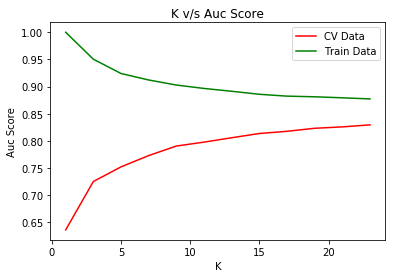

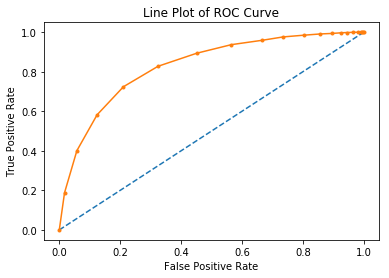

In [31]:
# find optimal k using brute force
KNN(bow_train,bow_cv,Y_tr,Y_cv)

### KNN with simple CV Over the unseen or Test data in BoW

AUC Score 0.7783899941007902
macro f1 score for data : 0.5862673994167019
micro f1 scoore for data: 0.8470139436990266
hamming loss for data: 0.15298605630097342
Precision recall report for data:
              precision    recall  f1-score   support

          0       0.66      0.16      0.26      2526
          1       0.85      0.98      0.91     12678

avg / total       0.82      0.85      0.81     15204



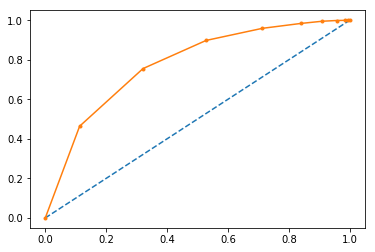

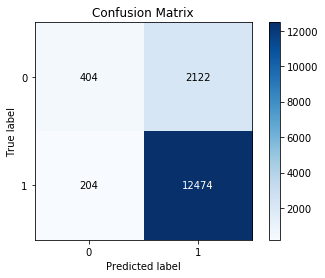

In [24]:
#algorithm = brute force, optimal_k=11
testing(bow_train,Y_tr,bow_test,Y_test,'brute',optimal_k=9)

##  TF-IDF

In [28]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
tfidf_train = tf_idf_vect.fit_transform(X_tr)
print("The type of count vectorizer ",type(tfidf_train))
print("The shape of out text TFIDF vectorizer ",tfidf_train.get_shape())
tfidf_cv = tf_idf_vect.transform(X_cv)
tfidf_test = tf_idf_vect.transform(X_test)
print("CV Data Size: ",tfidf_cv.shape)
print("Test Data Size: ",tfidf_test.shape)

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text TFIDF vectorizer  (20680, 397694)
CV Data Size:  (10187, 397694)
Test Data Size:  (15204, 397694)


In [29]:
#Normalize Data
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
tfidf_train=preprocessing.normalize(tfidf_train)
tfidf_cv=preprocessing.normalize(tfidf_cv)
tfidf_test=preprocessing.normalize(tfidf_test)
print("The shape of out text BOW vectorizer ",tfidf_train.get_shape())
print("CV Data Size: ",tfidf_cv.shape)
print("Test Data Size: ",tfidf_test.shape)

The shape of out text BOW vectorizer  (20680, 397694)
CV Data Size:  (10187, 397694)
Test Data Size:  (15204, 397694)


1  ------>  0.6144461669031358
3  ------>  0.7155889372677193
5  ------>  0.7479457346529649
7  ------>  0.7738336066609608
9  ------>  0.7833393048957717
11  ------>  0.7951199530125395
13  ------>  0.8034872967275358
15  ------>  0.8133459035321013
17  ------>  0.8178875460253088
19  ------>  0.8234124858549363
21  ------>  0.8294945042478272
23  ------>  0.8345708588710373


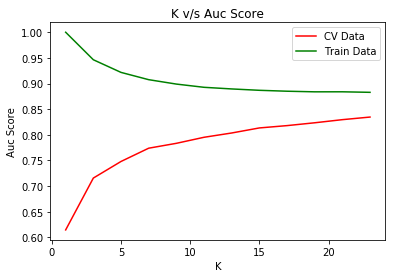

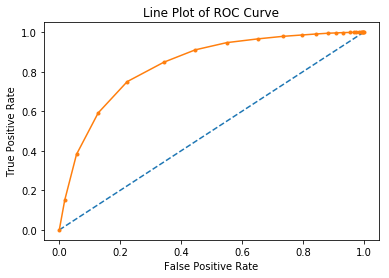

In [38]:
# find optimal_k
KNN(tfidf_train,tfidf_cv,Y_tr,Y_cv)

### KNN with simple CV Over the unseen or Test data in TF-IDF

AUC Score 0.7833233847400195
macro f1 score for data : 0.5953638628151352
micro f1 scoore for data: 0.851223362273086
hamming loss for data: 0.14877663772691396
Precision recall report for data:
              precision    recall  f1-score   support

          0       0.72      0.17      0.27      2526
          1       0.86      0.99      0.92     12678

avg / total       0.83      0.85      0.81     15204



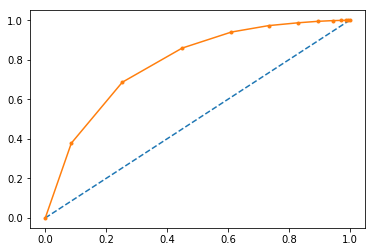

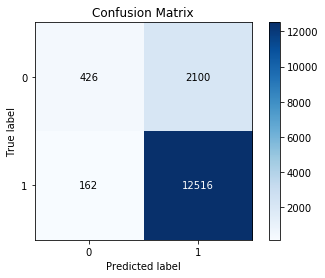

In [28]:
##algorithm = brute force, optimal_k=11
testing(tfidf_train,Y_tr,tfidf_test,Y_test,'brute',optimal_k=11)

## Avg W2V

In [39]:
# Train our own Word2Vec model using our own text corpus
import gensim
i=0
list_of_sent=[]
for sent in final_reviews['CleanedText'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [40]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [41]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)    

In [42]:
# split data into Train, CV and Test
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(sent_vectors,Y, test_size=.33, random_state=0)
X_tr1, X_cv1, Y_tr1, Y_cv1 = train_test_split(X_train1, Y_train1, test_size=.33, random_state=0)
train_avgw2v=preprocessing.normalize(X_tr1)
cv_avgw2v=preprocessing.normalize(X_cv1)
test_avgw2v=preprocessing.normalize(X_test1)
print(train_avgw2v.shape)
print(cv_avgw2v.shape)
print(test_avgw2v.shape)
#print(len(X_train1))

(20680, 50)
(10187, 50)
(15204, 50)


1  ------>  0.6932933370287612
3  ------>  0.8052122764792722
5  ------>  0.837527356696862
7  ------>  0.8560801874328647
9  ------>  0.8644852273836946
11  ------>  0.8720550982543411
13  ------>  0.8758348818707672
15  ------>  0.8793182294688349
17  ------>  0.881599641562649
19  ------>  0.8847884918059153
21  ------>  0.8872856340722273
23  ------>  0.8892959922798109


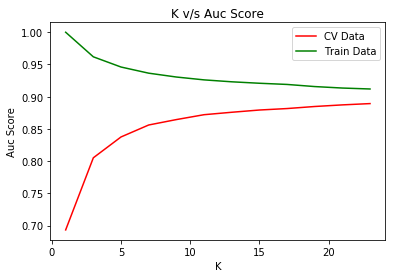

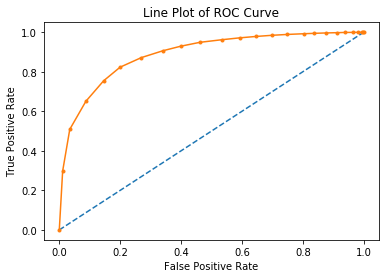

In [43]:
# find optimal k using brute force
KNN(train_avgw2v,cv_avgw2v,Y_tr1,Y_cv1)

### KNN with simple CV Over the unseen or Test data in AvgW2V

AUC Score 0.8391284357776148
macro f1 score for data : 0.7079151417693392
micro f1 scoore for data: 0.8680610365693239
hamming loss for data: 0.13193896343067613
Precision recall report for data:
              precision    recall  f1-score   support

          0       0.68      0.38      0.49      2526
          1       0.89      0.96      0.92     12678

avg / total       0.85      0.87      0.85     15204



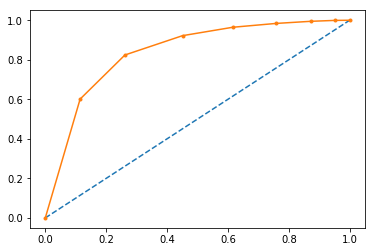

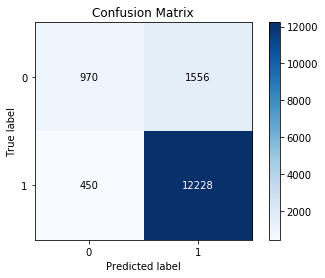

In [44]:
#algorithm = brute force, optimal_k=7
testing(train_avgw2v,Y_tr1,test_avgw2v,Y_test1,'brute',optimal_k=7)

## TF-IDF Weighted Word2Vec

In [45]:
#tf-idf weighted w2v

from sklearn.feature_extraction.text import TfidfVectorizer

tfidfw2v_vect = TfidfVectorizer()
tfidfw2v= tfidfw2v_vect.fit_transform(final_reviews['CleanedText'].values) 
print(type(tfidfw2v))
print(tfidfw2v.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(46071, 24780)


In [46]:
# TF-IDF weighted Word2Vec
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
t=tfidfw2v_vect.get_feature_names()
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent:
    sent_vec = np.zeros(50)
    cnt_words = 0;
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tfidf = tfidfw2v[row,t.index(word)]
            sent_vec += (vec*tfidf)
            cnt_words += tfidf
        except:
            pass
    sent_vec /= cnt_words
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [47]:
#split dataset
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(tfidf_sent_vectors, final['Score'], test_size=0.33,random_state=0)
X_tr2, X_cv2, Y_tr2, Y_cv2 = train_test_split(X_train2, Y_train2, test_size=.33, random_state=0)
train_tfidfw2v=preprocessing.normalize(X_tr2)
cv_tfidfw2v=preprocessing.normalize(X_cv2)
test_tfidfw2v=preprocessing.normalize(X_test2)
print(train_tfidfw2v.shape)
print(cv_tfidfw2v.shape)
print(test_tfidfw2v.shape)

(20680, 50)
(10187, 50)
(15204, 50)


1  ------>  0.4955785665273532
3  ------>  0.492992604606353
5  ------>  0.48719120592740456
7  ------>  0.4869965830093083
9  ------>  0.4848899008171667
11  ------>  0.4874500447050506
13  ------>  0.48559745354486794
15  ------>  0.4879585733197485
17  ------>  0.48605001420858196
19  ------>  0.48485884986727107
21  ------>  0.48303419069996323
23  ------>  0.4793928776883677


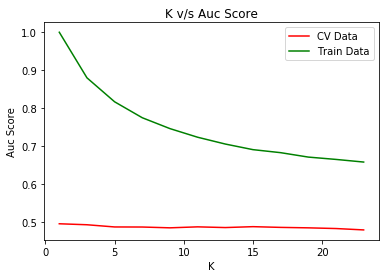

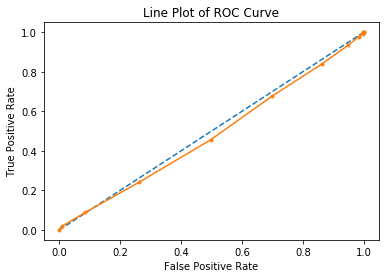

In [48]:
# find optimal k using brute force
KNN(train_tfidfw2v,cv_tfidfw2v,Y_tr2,Y_cv2)

### KNN with simple CV Over the unseen or Test data in TF-IDF W2V

AUC Score 0.5071521245926147
macro f1 score for data : 0.5069221511818535
micro f1 scoore for data: 0.725203893712181
hamming loss for data: 0.274796106287819
Precision recall report for data:
              precision    recall  f1-score   support

          0       0.17      0.18      0.18      2475
          1       0.84      0.83      0.83     12729

avg / total       0.73      0.73      0.73     15204



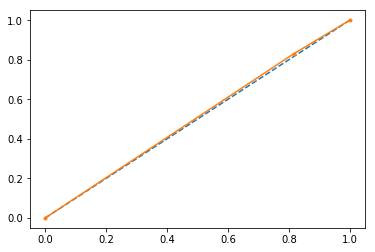

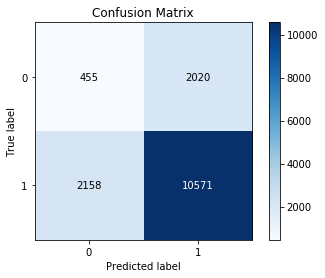

In [39]:
#algorithm = brute, optimal_k= 1
testing(train_tfidfw2v,Y_tr2,test_tfidfw2v,Y_test2,'brute',optimal_k=1)

# K-NN using KD-Tree with Simple CV

In [23]:
#find knn to simple cross validation with KD-Tree
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import roc_auc_score
def KNN_kdtree(X_train,X_cv,Y_train,Y_cv,n_components):
    k = []
    max_k = 0
    pred_cv = []
    pred_train = []
    max_roc_auc=-1
    svd = TruncatedSVD(n_components=n_components)
    X_train = svd.fit_transform(X_train)
    X_cv = svd.fit_transform(X_cv)
    for i in range(1,24,2):
        knn =KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')
        knn.fit(X_train,Y_train)
        probs = knn.predict_proba(X_cv)
        prob = knn.predict_proba(X_train)
        # keep probabilities for the positive outcome only
        probs = probs[:, 1]
        prob = prob[:,1]
        auc_score_test = roc_auc_score(Y_cv,probs) #find AUC score
        auc_score_train = roc_auc_score(Y_train,prob)
        print(i," ------> ",auc_score_test)
        pred_cv.append(auc_score_test)
        pred_train.append(auc_score_train)
        k.append(i)
        if(max_roc_auc<auc_score_test):
            max_roc_auc=auc_score_test
            max_k=i
    #print('\nThe optimal number of neighbors is %d.' % max_k)
    plt.plot(k, pred_cv,'r-', label = 'CV Data')
    plt.plot(k,pred_train,'g-', label ='Train Data')
    plt.legend(loc='upper right')
    plt.title("K v/s Auc Score")
    plt.ylabel('Auc Score')
    plt.xlabel('K')
    plt.show()
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(Y_cv,probs)
    # plot no skill
    pyplt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    pyplt.plot(fpr, tpr, marker='.')
    #plt.plot(k,pred_cv)
    pyplt.title("Line Plot of ROC Curve")
    pyplt.ylabel('True Positive Rate')
    pyplt.xlabel('False Positive Rate')
    pyplt.show()

In [24]:
# for KD TREE take 30k data point
final_review = final_reviews.head(30000) #Sampled amazon fine foood reviews final revievs data to 30k datapoints for time effiecieny
final_review.shape

(30000, 12)

## Spliting dataset  

In [25]:
#split data into train, cross validate and test 
%matplotlib inline
import warnings
from sklearn.cross_validation import train_test_split
X = final_review['CleanedText']
Y = final_review['Score']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.33, random_state=0)
X_tr, X_cv, Y_tr, Y_cv = train_test_split(X_train, Y_train, test_size=.33, random_state=0)

In [26]:
print('X_train, Y_train', X_train.shape, Y_train.shape)
print('X_test, Y_test', X_test.shape, Y_test.shape)
print('X_tr, Y_tr', X_tr.shape, Y_tr.shape)
print('X_cv, Y_cv', X_cv.shape, Y_cv.shape)

X_train, Y_train (20100,) (20100,)
X_test, Y_test (9900,) (9900,)
X_tr, Y_tr (13467,) (13467,)
X_cv, Y_cv (6633,) (6633,)


# Techniques for vectorization :-- 

##  Bag of Words (BoW) 

In [27]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
bow_train = count_vect.fit_transform(X_tr)
print("The type of count vectorizer ",type(bow_train))
print("The shape of out text BOW vectorizer ",bow_train.get_shape())
#print("the number of unique words ", final_counts.get_shape()[1])
bow_cv = count_vect.transform(X_cv)
bow_test = count_vect.transform(X_test)
print("CV Data Size: ",bow_cv.shape)
print("Test Data Size: ",bow_test.shape)

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text BOW vectorizer  (13467, 14215)
CV Data Size:  (6633, 14215)
Test Data Size:  (9900, 14215)


In [28]:
#Normalize Data
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
bow_train=preprocessing.normalize(bow_train)
bow_cv=preprocessing.normalize(bow_cv)
bow_test=preprocessing.normalize(bow_test)
print("The shape of out text BOW vectorizer ",bow_train.get_shape())
print("CV Data Size: ",bow_cv.shape)
print("Test Data Size: ",bow_test.shape)

The shape of out text BOW vectorizer  (13467, 14215)
CV Data Size:  (6633, 14215)
Test Data Size:  (9900, 14215)


Text(0,0.5,'Cumulative explained variance')

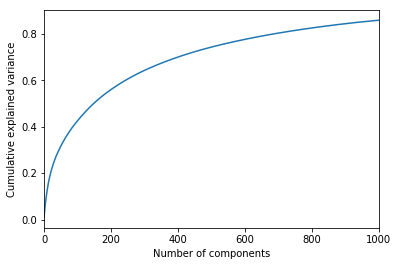

In [29]:
# explain variance of training data
from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(n_components=1000).fit(bow_train)
plt.plot(np.cumsum(tsvd.explained_variance_ratio_))
plt.xlim(0,1000,10)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

1  ------>  0.5013675532438949
3  ------>  0.49796017578590424
5  ------>  0.4941218051361911
7  ------>  0.5046562094212708
9  ------>  0.5131583746997025
11  ------>  0.5172917161693781
13  ------>  0.5217282102558141
15  ------>  0.5319000586703012
17  ------>  0.5362412689148652
19  ------>  0.5513099227127021
21  ------>  0.5533552866850462
23  ------>  0.55904819794221


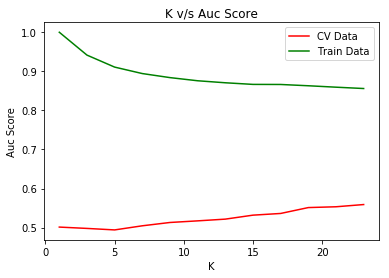

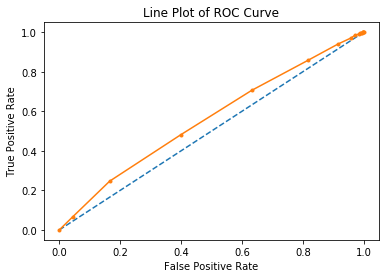

In [30]:
# find optimal k using kd_tree
KNN_kdtree(bow_train,bow_cv,Y_tr,Y_cv,n_components=1000)

### KNN with simple CV Over the unseen or Test data in BoW

AUC Score 0.796098497993102
macro f1 score for data : 0.5624376964956675
micro f1 scoore for data: 0.8658585858585859
hamming loss for data: 0.13414141414141414
Precision recall report for data:
              precision    recall  f1-score   support

          0       0.73      0.11      0.20      1432
          1       0.87      0.99      0.93      8468

avg / total       0.85      0.87      0.82      9900



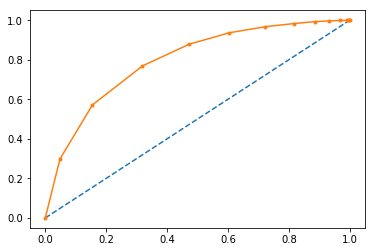

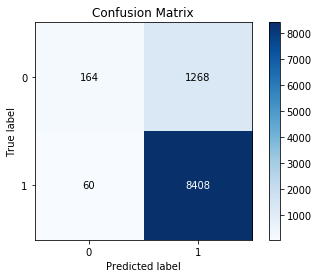

In [31]:
#algorithm = kd_tree, optimal_k=9
testing(bow_train,Y_tr,bow_test,Y_test,'kd_tree',optimal_k=15)

## TF-IDF 

In [32]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
tfidf_train = tf_idf_vect.fit_transform(X_tr)
print("The type of count vectorizer ",type(tfidf_train))
print("The shape of out text TFIDF vectorizer ",tfidf_train.get_shape())
tfidf_cv = tf_idf_vect.transform(X_cv)
tfidf_test = tf_idf_vect.transform(X_test)
print("CV Data Size: ",tfidf_cv.shape)
print("Test Data Size: ",tfidf_test.shape)

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text TFIDF vectorizer  (13467, 286236)
CV Data Size:  (6633, 286236)
Test Data Size:  (9900, 286236)


In [33]:
#Normalize Data
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
tfidf_train=preprocessing.normalize(tfidf_train)
tfidf_cv=preprocessing.normalize(tfidf_cv)
tfidf_test=preprocessing.normalize(tfidf_test)
print("The shape of out text BOW vectorizer ",tfidf_train.get_shape())
print("CV Data Size: ",tfidf_cv.shape)
print("Test Data Size: ",tfidf_test.shape)

The shape of out text BOW vectorizer  (13467, 286236)
CV Data Size:  (6633, 286236)
Test Data Size:  (9900, 286236)


Text(0,0.5,'Cumulative explained variance')

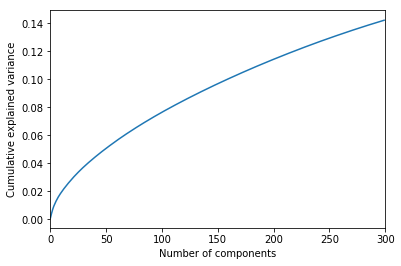

In [34]:
from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(n_components=300).fit(tfidf_train)
plt.plot(np.cumsum(tsvd.explained_variance_ratio_))
plt.xlim(0,300,10)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

1  ------>  0.49961051238161536
3  ------>  0.516600183885883
5  ------>  0.5297688710586325
7  ------>  0.5418055725536172
9  ------>  0.5447341444448497
11  ------>  0.5490690478877157
13  ------>  0.5486312365319954
15  ------>  0.553966364633365
17  ------>  0.5607491594056061
19  ------>  0.5627709154851073
21  ------>  0.5654263346811708
23  ------>  0.565310937255505


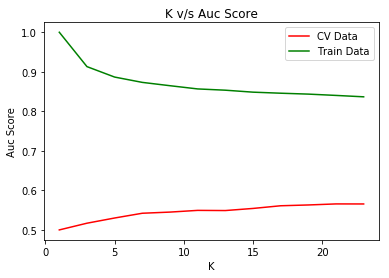

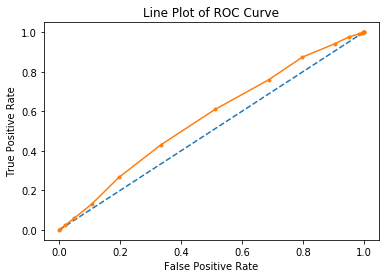

In [35]:
# find optimal_k
KNN_kdtree(tfidf_train,tfidf_cv,Y_tr,Y_cv,n_components=300)

### KNN with simple CV Over the unseen or Test data in TF-IDF

AUC Score 0.7607538435859746
macro f1 score for data : 0.6075077811021925
micro f1 scoore for data: 0.8665656565656565
hamming loss for data: 0.13343434343434343
Precision recall report for data:
              precision    recall  f1-score   support

          0       0.63      0.19      0.29      1432
          1       0.88      0.98      0.93      8468

avg / total       0.84      0.87      0.83      9900



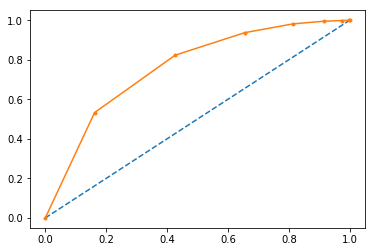

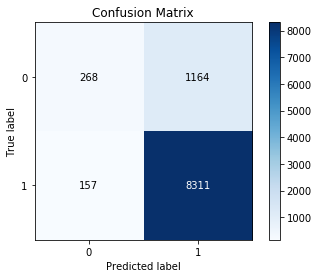

In [36]:
#algorithm = brute force, optimal_k=11
testing(bow_train,Y_tr,bow_test,Y_test,'kd_tree',optimal_k=7)

## Avg W2V 

In [37]:
# Train our own Word2Vec model using our own text corpus
import gensim
i=0
list_of_sent=[]
for sent in final_review['CleanedText'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [38]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [39]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)    

In [40]:
# split data into Train, CV and Test
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(sent_vectors,Y, test_size=.33, random_state=0)
X_tr1, X_cv1, Y_tr1, Y_cv1 = train_test_split(X_train1, Y_train1, test_size=.33, random_state=0)
train_avgw2v=preprocessing.normalize(X_tr1)
cv_avgw2v=preprocessing.normalize(X_cv1)
test_avgw2v=preprocessing.normalize(X_test1)
print(train_avgw2v.shape)
print(cv_avgw2v.shape)
print(test_avgw2v.shape)
#print(len(X_train1))

(13467, 50)
(6633, 50)
(9900, 50)


Text(0,0.5,'Cumulative explained variance')

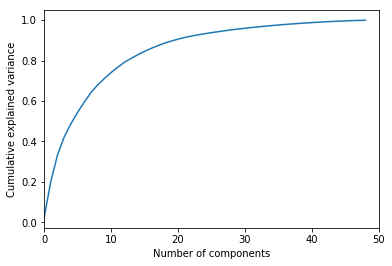

In [41]:
from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(n_components=49).fit(train_avgw2v)
plt.plot(np.cumsum(tsvd.explained_variance_ratio_))
plt.xlim(0,50,10)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

1  ------>  0.6009321793818039
3  ------>  0.6740593746175436
5  ------>  0.7054419346403981
7  ------>  0.725512649228303
9  ------>  0.7395923283382327
11  ------>  0.7547860954454323
13  ------>  0.7632049086689887
15  ------>  0.7672090459309027
17  ------>  0.7729624683935485
19  ------>  0.7764031696280794
21  ------>  0.7801910858642074
23  ------>  0.7847310455893127


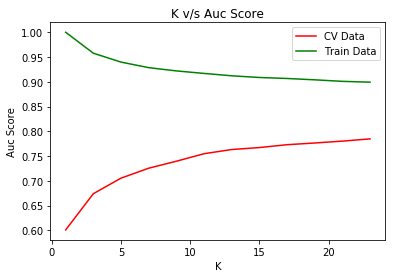

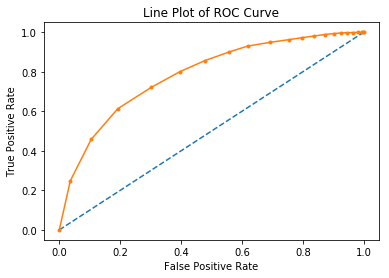

In [42]:
# find optimal k using kd_tree
KNN_kdtree(train_avgw2v,cv_avgw2v,Y_tr1,Y_cv1,n_components=49)

### KNN with simple CV Over the unseen or Test data in AvgW2V

AUC Score 0.8400437615287788
macro f1 score for data : 0.6723577167561443
micro f1 scoore for data: 0.8776767676767677
hamming loss for data: 0.12232323232323232
Precision recall report for data:
              precision    recall  f1-score   support

          0       0.68      0.30      0.41      1432
          1       0.89      0.98      0.93      8468

avg / total       0.86      0.88      0.86      9900



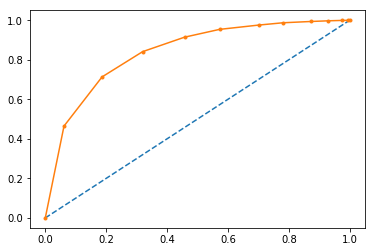

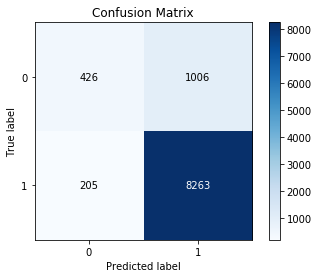

In [43]:
#algorithm = brute force, optimal_k=7
testing(train_avgw2v,Y_tr1,test_avgw2v,Y_test1,'brute',optimal_k=11)

## TF-IDF Weighted Word2Vec

In [44]:
#tf-idf weighted w2v

from sklearn.feature_extraction.text import TfidfVectorizer

tfidfw2v_vect = TfidfVectorizer()
tfidfw2v= tfidfw2v_vect.fit_transform(final_review['CleanedText'].values) 
print(type(tfidfw2v))
print(tfidfw2v.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(30000, 20418)


In [45]:
# TF-IDF weighted Word2Vec
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
t=tfidfw2v_vect.get_feature_names()
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent:
    sent_vec = np.zeros(50)
    cnt_words = 0;
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tfidf = tfidfw2v[row,t.index(word)]
            sent_vec += (vec*tfidf)
            cnt_words += tfidf
        except:
            pass
    sent_vec /= cnt_words
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [46]:
#split dataset
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(tfidf_sent_vectors, final_review['Score'], test_size=0.33,random_state=0)
X_tr2, X_cv2, Y_tr2, Y_cv2 = train_test_split(X_train2, Y_train2, test_size=.33, random_state=0)
train_tfidfw2v=preprocessing.normalize(X_tr2)
cv_tfidfw2v=preprocessing.normalize(X_cv2)
test_tfidfw2v=preprocessing.normalize(X_test2)
print(train_tfidfw2v.shape)
print(cv_tfidfw2v.shape)
print(test_tfidfw2v.shape)

(13467, 50)
(6633, 50)
(9900, 50)


Text(0,0.5,'Cumulative wexplained variance')

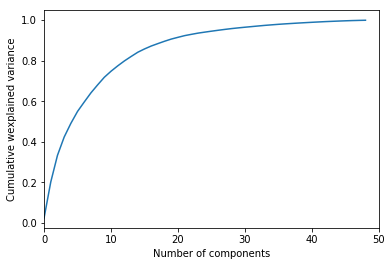

In [47]:
from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(n_components=49).fit(train_tfidfw2v)
plt.plot(np.cumsum(tsvd.explained_variance_ratio_))
plt.xlim(0,50,10)
plt.xlabel('Number of components')
plt.ylabel('Cumulative wexplained variance')

1  ------>  0.587468265707942
3  ------>  0.6547239990168208
5  ------>  0.6904296159225949
7  ------>  0.707609599429456
9  ------>  0.7240357496792906
11  ------>  0.7325540228701676
13  ------>  0.7438679989813664
15  ------>  0.748139408272001
17  ------>  0.7530697078859907
19  ------>  0.758180092256577
21  ------>  0.7605061089044881
23  ------>  0.7615624981889253


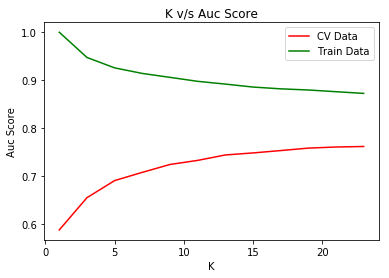

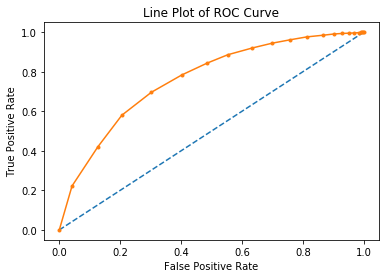

In [48]:
# find optimal k using brute force
KNN_kdtree(train_tfidfw2v,cv_tfidfw2v,Y_tr2,Y_cv2,n_components=49)

### KNN with simple CV Over the unseen or Test data in AvgW2V 

AUC Score 0.8095103518207224
macro f1 score for data : 0.6548574494800348
micro f1 scoore for data: 0.8725252525252525
hamming loss for data: 0.12747474747474746
Precision recall report for data:
              precision    recall  f1-score   support

          0       0.64      0.27      0.38      1432
          1       0.89      0.97      0.93      8468

avg / total       0.85      0.87      0.85      9900



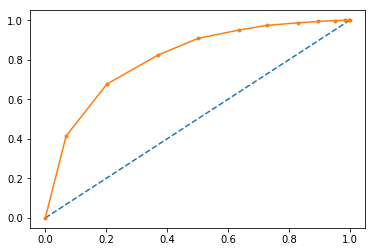

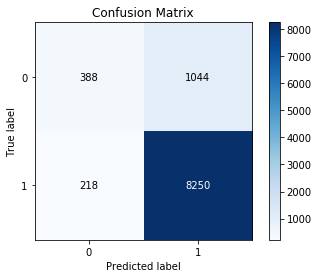

In [49]:
#algorithm = brute, optimal_k= 1
testing(train_tfidfw2v,Y_tr2,test_tfidfw2v,Y_test2,'kd_tree',optimal_k=11)

In [50]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Best hyper parameter(K)","Test Auc Score"]

x.add_row(["BoW","Brute",9,77.83])
x.add_row(["BoW","KD-Tree",15,79.60])
x.add_row(["Tf-Idf","Brute",11,78.33])
x.add_row(["Tf-Idf","KD-Tree",7,76.07])
x.add_row(["Avg Word2Vec","Brute",7,83.91])
x.add_row(["Avg Word2Vec","KD-Tree",11,84.00])
x.add_row(["tf idf-Word2vec","Brute",1,51.7])
x.add_row(["tf idf-Word2vec","KD-Tree",11,80.95])
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
printmd('****Final Conclusion:****')
print(x)

****Final Conclusion:****

+-----------------+---------+-------------------------+----------------+
|    Vectorizer   |  Model  | Best hyper parameter(K) | Test Auc Score |
+-----------------+---------+-------------------------+----------------+
|       BoW       |  Brute  |            9            |     77.83      |
|       BoW       | KD-Tree |            15           |      79.6      |
|      Tf-Idf     |  Brute  |            11           |     78.33      |
|      Tf-Idf     | KD-Tree |            7            |     76.07      |
|   Avg Word2Vec  |  Brute  |            7            |     83.91      |
|   Avg Word2Vec  | KD-Tree |            11           |      84.0      |
| tf idf-Word2vec |  Brute  |            1            |      51.7      |
| tf idf-Word2vec | KD-Tree |            11           |     80.95      |
+-----------------+---------+-------------------------+----------------+
